In [1]:
import corner
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy import units as u
import matplotlib
from pm_func_edr3 import *
import emcee

In [2]:
def log_prob(p):
    return np.logaddexp(-0.5 * np.sum(p ** 2), -0.5 * np.sum((p - 4.0) ** 2))


sampler = emcee.EnsembleSampler(32, 3, log_prob)
sampler.run_mcmc(
    np.concatenate(
        (np.random.randn(16, 3), 4.0 + np.random.randn(16, 3)), axis=0
    ),
    500000,
    progress=True,
);

100%|████████████████████████████████████████████████████████████████████████| 500000/500000 [05:53<00:00, 1415.35it/s]


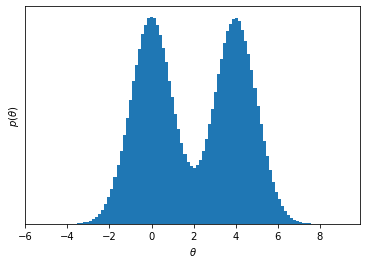

In [3]:
chain = sampler.get_chain()[:, :, 0].T

plt.hist(chain.flatten(), 100)
plt.gca().set_yticks([])
plt.xlabel(r"$\theta$")
plt.ylabel(r"$p(\theta)$");

In [11]:
def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i

def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))

    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2 * n)
    acf = np.fft.ifft(f * np.conjugate(f))[: len(x)].real
    acf /= 4 * n

    # Optionally normalize
    if norm:
        acf /= acf[0]

    return acf

# Automated windowing procedure following Sokal (1989)
def auto_window(taus, c):
    m = np.arange(len(taus)) < c * taus
    if np.any(m):
        return np.argmin(m)
    return len(taus) - 1

# Following the suggestion from Goodman & Weare (2010)
def autocorr_gw2010(y, c=5.0):
    f = autocorr_func_1d(np.mean(y, axis=0))
    taus = 2.0 * np.cumsum(f) - 1.0
    window = auto_window(taus, c)
    return taus[window]


def autocorr_new(y, c=5.0):
    f = np.zeros(y.shape[1])
    for yy in y:
        f += autocorr_func_1d(yy)
    f /= len(y)
    taus = 2.0 * np.cumsum(f) - 1.0
    window = auto_window(taus, c)
    return taus[window]

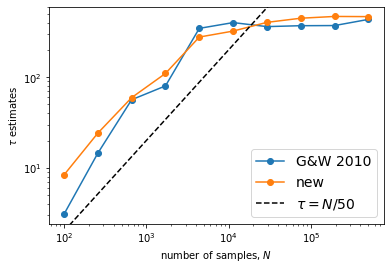

In [12]:
# Compute the estimators for a few different chain lengths
N = np.exp(np.linspace(np.log(100), np.log(chain.shape[1]), 10)).astype(int)
gw2010 = np.empty(len(N))
new = np.empty(len(N))
for i, n in enumerate(N):
    gw2010[i] = autocorr_gw2010(chain[:, :n])
    new[i] = autocorr_new(chain[:, :n])

# Plot the comparisons
plt.loglog(N, gw2010, "o-", label="G&W 2010")
plt.loglog(N, new, "o-", label="new")
ylim = plt.gca().get_ylim()
plt.plot(N, N / 50.0, "--k", label=r"$\tau = N/50$")
plt.ylim(ylim)
plt.xlabel("number of samples, $N$")
plt.ylabel(r"$\tau$ estimates")
plt.legend(fontsize=14);

Alright, now we'll do the analysis for our SMC MCMC results.

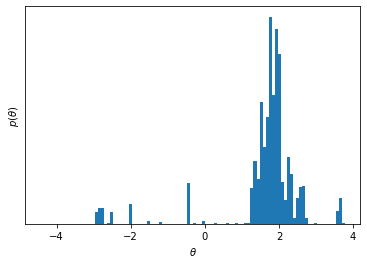

In [13]:
dir = "D:/pzivi/Research/Gurtina_Project/"

datasource = "allstar_Model2"
data = Table.read(dir + "Data/"+datasource+".fits")

perm = 'standard'
priors, nparams, params = get_priors(perm)

nwalk = 100
nsamp = 1500
#ver = "_nw" + str(nwalk) + "_ns" + str(nsamp)
ver = ""

outfilecore = datasource + "_" + perm

smc_chain = np.loadtxt('MCMC/' + outfilecore + ver + "_marginalized_density.txt")

plt.hist(smc_chain.flatten(), 100)
plt.gca().set_yticks([])
plt.xlabel(r"$\theta$")
plt.ylabel(r"$p(\theta)$");

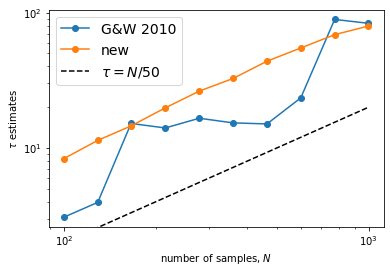

In [14]:
# Compute the estimators for a few different chain lengths
smc_N = np.exp(np.linspace(np.log(100), np.log(smc_chain.shape[1]), 10)).astype(int)
gw2010 = np.empty(len(smc_N))
new = np.empty(len(smc_N))
for i, n in enumerate(smc_N):
    gw2010[i] = autocorr_gw2010(chain[:, :n])
    new[i] = autocorr_new(chain[:, :n])

# Plot the comparisons
plt.loglog(smc_N, gw2010, "o-", label="G&W 2010")
plt.loglog(smc_N, new, "o-", label="new")
ylim = plt.gca().get_ylim()
plt.plot(smc_N, smc_N / 50.0, "--k", label=r"$\tau = N/50$")
plt.ylim(ylim)
plt.xlabel("number of samples, $N$")
plt.ylabel(r"$\tau$ estimates")
plt.legend(fontsize=14);